<a href="https://colab.research.google.com/github/OleksandrArtemenko/ab_testing_analysis_porfolio/blob/main/ab_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import auth
from google.cloud import bigquery
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest
import math

In [ ]:
# # Версія коду, яка використовувалась початково для вивантаження даних, але яка не буде працювати без відповідних прав
# auth.authenticate_user()
# client = bigquery.Client(project="data-analytics-mate")

Основними завданнями мініпроекту будуть:
- розробити інструментарій порівняння різних метрик для контрольної та експериментальної групи у АВ-тестуванні, а також оцінки статистичної значущості результатів для двох груп;
- власне, провести дослідження ряду важливих метрик для датасету, що містить результати контрольних та експериментальних груп для декількох тестів, зробити висновки щодо досліджуваних даних.

In [ ]:
# Версія коду, яка використовувалась початково для вивантаження даних, але яка не буде працювати без відповідних прав
query = """
WITH session_test AS (
SELECT
  ab.ga_session_id,
  s.date,
  sp.country,
  sp.device,
  sp.continent,
  sp.channel,
  ab.test,
  ab.test_group
FROM `data-analytics-mate.DA.ab_test` ab
JOIN `data-analytics-mate.DA.session` s
USING(ga_session_id)
JOIN `data-analytics-mate.DA.session_params` sp
USING(ga_session_id)),
session_order AS (
SELECT
  st.date,
  st.country,
  st.device,
  st.continent,
  st.channel,
  st.test,
  st.test_group,
  COUNT(DISTINCT o.ga_session_id) AS value
FROM session_test st
JOIN `data-analytics-mate.DA.order` o
USING(ga_session_id)
GROUP BY
  st.date,
  st.country,
  st.device,
  st.continent,
  st.channel,
  st.test,
  st.test_group),
session_event AS (
SELECT
  st.date,
  st.country,
  st.device,
  st.continent,
  st.channel,
  st.test,
  st.test_group,
  ep.event_name,
  COUNT(ep.ga_session_id) AS value
FROM session_test st
JOIN `data-analytics-mate.DA.event_params` ep
USING(ga_session_id)
GROUP BY
  st.date,
  st.country,
  st.device,
  st.continent,
  st.channel,
  st.test,
  st.test_group,
  ep.event_name),
sessions AS (
SELECT
  st.date,
  st.country,
  st.device,
  st.continent,
  st.channel,
  st.test,
  st.test_group,
  COUNT(DISTINCT st.ga_session_id) AS value
FROM session_test st
GROUP BY
  st.date,
  st.country,
  st.device,
  st.continent,
  st.channel,
  st.test,
  st.test_group),
session_new_accs AS (
SELECT
  st.date,
  st.country,
  st.device,
  st.continent,
  st.channel,
  st.test,
  st.test_group,
  COUNT(DISTINCT acs.ga_session_id) AS value
FROM session_test st
JOIN `data-analytics-mate.DA.account_session` acs
USING(ga_session_id)
GROUP BY
  st.date,
  st.country,
  st.device,
  st.continent,
  st.channel,
  st.test,
  st.test_group)
SELECT
  so.date,
  so.country,
  so.device,
  so.continent,
  so.channel,
  so.test,
  so.test_group,
  'session_with_orders' AS event_name,
  so.value
FROM session_order so
UNION ALL
SELECT
  se.date,
  se.country,
  se.device,
  se.continent,
  se.channel,
  se.test,
  se.test_group,
  se.event_name,
  se.value
FROM session_event se
UNION ALL
SELECT
  ss.date,
  ss.country,
  ss.device,
  ss.continent,
  ss.channel,
  ss.test,
  ss.test_group,
  'session',
  ss.value
FROM sessions ss
UNION ALL
SELECT
  sna.date,
  sna.country,
  sna.device,
  sna.continent,
  sna.channel,
  sna.test,
  sna.test_group,
  'new_account',
  sna.value
FROM session_new_accs sna
"""

In [ ]:
# # Версія коду, яка використовувалась початково для вивантаження даних, але яка не буде працювати без відповідних прав
# query_job = client.query(query)
# results = query_job.result()
# df = results.to_dataframe()

In [10]:
# Версія коду, яка вивантажує дані із готового csv файлу (завантажити на Github одним файлом неможливо через перевищення ліміту розміру файлу)
url = 'https://drive.google.com/uc?id=1MHqUn-vO1kVZ4sxQwu4Rt2-1CnzkOkvX'
df = pd.read_csv(url)

Датасет представляє собою набір даних щодо діяльності інтернет-магазину меблів у ході проведення 4 АВ-тестів. Суть цих тестів невідома, тому вибір метрик залишається на наш розсуд. Відомо, що перша група є контрольною, тобто тою, що використовувала існуючий функціонал сервісу, а друга - експериментальною, що тестувала ті чи інші зміни.

Для початку, проведемо короткий огляд даних.

In [ ]:
df.head()

,date,country,device,continent,channel,test,test_group,event_name,value
0,2020-11-03,Qatar,mobile,Asia,Organic Search,2,2,new_account,1
1,2020-11-03,Ecuador,mobile,Americas,Direct,2,2,new_account,1
2,2020-11-12,New Zealand,mobile,Oceania,Undefined,2,2,new_account,1
3,2020-11-12,Bulgaria,mobile,Europe,Paid Search,2,2,new_account,1
4,2020-11-15,Bulgaria,desktop,Europe,Social Search,2,2,new_account,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800996 entries, 0 to 800995
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   date        800996 non-null  dbdate
 1   country     800996 non-null  object
 2   device      800996 non-null  object
 3   continent   800996 non-null  object
 4   channel     800996 non-null  object
 5   test        800996 non-null  Int64 
 6   test_group  800996 non-null  Int64 
 7   event_name  800996 non-null  object
 8   value       800996 non-null  Int64 
dtypes: Int64(3), dbdate(1), object(5)
memory usage: 57.3+ MB


In [ ]:
df.dtypes

,0
date,dbdate
country,object
device,object
continent,object
channel,object
test,Int64
test_group,Int64
event_name,object
value,Int64


In [ ]:
df['date'] = pd.to_datetime(df['date'])
df.dtypes

,0
date,datetime64[ns]
country,object
device,object
continent,object
channel,object
test,Int64
test_group,Int64
event_name,object
value,Int64


Отже, відсутні пусті значення. Наявні формати в цілому підходять для виконання завдань дослідження.

Також перевіримо датасет з точки зору наявності дубльованих даних.

In [ ]:
df.duplicated(subset=['date', 'country', 'device', 'continent', 'channel', 'test', 'test_group', 'event_name']).any()

np.False_

Дублікати відсутні.

Також оглянемо розмірність тестів.

In [ ]:
df[['test', 'test_group']].value_counts()

test  test_group
4     1             151650
      2             151174
3     2             100998
      1              99759
2     1              79303
      2              77488
1     2              70524
      1              70100
Name: count, dtype: int64

Окрім цього, ознайомимось з розподілом подій у датасеті.

In [ ]:
df['event_name'].value_counts()

,count
event_name,
session,107210
session_start,106242
page_view,101907
user_engagement,94520
first_visit,81621
scroll,73643
view_promotion,61695
view_item,44869
session_with_orders,25892


На завершення огляду даних, ознайомимось із рештою характеристик.

In [ ]:
top_5_countries = df.groupby('country')['value'].sum().sort_values(ascending=False).nlargest(5).index.to_list()
print(top_5_countries)

['United States', 'India', 'Canada', 'United Kingdom', 'France']


In [ ]:
df['device'].value_counts()

,count
device,
desktop,419152
mobile,335832
tablet,46012


In [ ]:
df['continent'].value_counts()

,count
continent,
Europe,289723
Asia,285747
Americas,171834
Africa,28652
Oceania,19040
(not set),6000


In [ ]:
df['channel'].value_counts()

,count
channel,
Organic Search,237152
Paid Search,204056
Direct,188716
Social Search,96068
Undefined,75004


На завершення ознайомлення з даними, оглянемо їх загальні характеристики.

In [ ]:
df.describe()

,date,test,test_group,value
count,800996,800996.0,800996.0,800996.0
mean,2020-12-07 00:33:34.715678976,2.831191,1.499608,9.475863
min,2020-11-01 00:00:00,1.0,1.0,1.0
25%,2020-11-19 00:00:00,2.0,1.0,1.0
50%,2020-12-05 00:00:00,3.0,1.0,2.0
75%,2020-12-20 00:00:00,4.0,2.0,5.0
max,2021-01-27 00:00:00,4.0,2.0,1575.0
std,NaN,1.11694,0.5,37.493267


In [ ]:
df.describe(include=['object', 'category'])

,country,device,continent,channel,event_name
count,800996,800996,800996,800996,800996
unique,108,3,6,5,19
top,United States,desktop,Europe,Organic Search,session
freq,53507,419152,289723,237152,107210


З-поміж дій користувача, наявних у датасеті, виберемо наступний перелік, який включає як проміжні дії користувача, такі як введення певної інформації, так і остаточні, наприклад створення аккаунту або оформлення замовлення.

add_payment_info / session

add_shipping_info / session

begin_checkout / session

new_accounts / session

select_promotion / session

view_promotion / session

add_to_cart / session

session with orders / session


Для прикладу, оглянемо декілька подій у розрізі тестів та груп.

In [ ]:
df[df['event_name'] == 'session'].groupby(['test', 'test_group'])['value'].sum().sort_index()

test  test_group
1     1              45362
      2              45193
2     1              50637
      2              50244
3     1              70047
      2              70439
4     1             105079
      2             105141
Name: value, dtype: Int64

In [ ]:
df[df['event_name'] == 'add_payment_info'].groupby(['test', 'test_group'])['value'].sum().sort_index()

test  test_group
1     1             1988
      2             2229
2     1             2344
      2             2409
3     1             3623
      2             3697
4     1             3731
      2             3601
Name: value, dtype: Int64

Враховуючи значну кількість подій, які можуть бути цікавими для дослідження, одиничні операції по групуванню та отриманню інформації по окремим подіям не є оптимальною. З цієї причини, створимо відповідну функцію, яка прийматиме перелік подій та формуватиме відповідний датасет з кількістю подій у розрізі тестів.

In [ ]:
def prepare_grouped_df(df, event_names):
  res = pd.DataFrame()
  for event_name in event_names:
    grouped = df[df['event_name'] == event_name].groupby(['test', 'test_group'])['value'].sum().sort_index().unstack(level=1)
    grouped['event_name'] = event_name
    res = pd.concat([res, grouped], axis=0)
  res.rename(columns={1: 'control', 2: 'treatment'}, inplace=True)
  res.columns.name = None
  res.reset_index()
  return res

Передамо у функцію цікаві нам події та протестуємо її.

In [ ]:
event_names = ['session', 'add_payment_info', 'add_shipping_info', 'begin_checkout', 'new_account', 'select_promotion', 'view_promotion', 'add_to_cart', 'session_with_orders']
grouped_df = prepare_grouped_df(df, event_names).reset_index()

grouped_df

,test,control,treatment,event_name
0,1,45362,45193,session
1,2,50637,50244,session
2,3,70047,70439,session
3,4,105079,105141,session
4,1,1988,2229,add_payment_info
5,2,2344,2409,add_payment_info
6,3,3623,3697,add_payment_info
7,4,3731,3601,add_payment_info
8,1,3034,3221,add_shipping_info
9,2,3480,3510,add_shipping_info


Отже, ми отримали датасет, звідки можемо брати агреговані дані для порівняння результатів між групами та визначення статистичної значущості результату.
Для здійснення такого аналізу будемо використовувати ztest, який підходить для оцінки часток подій для різних груп.

Для прикладу, проведемо аналіз для першої події add_payment_info / session.

In [ ]:
z, p = proportions_ztest([grouped_df.loc[(grouped_df['test'] == 1) & (grouped_df['event_name'] == 'add_payment_info'), 'control'], grouped_df.loc[(grouped_df['test'] == 1) & (grouped_df['event_name'] == 'session'), 'control']], [grouped_df.loc[(grouped_df['test'] == 1) & (grouped_df['event_name']== 'add_payment_info'), 'treatment'], grouped_df.loc[(grouped_df['test'] == 1) & (grouped_df['event_name'] == 'session'), 'treatment']])
print(p)
print(p < 0.05)

[0.]
[ True]


Отже, ми провели ztest для метрики add_payment_info / session. Отримане значення p-value свідчить про статистичну значущість різниці.
Однак, оскільки метрик багато, краще автоматизувати їх розрахунок за допомогою функції.

In [ ]:
def conduct_ztest(df, significance_criteria=0.05):

    session_counts = df[df['event_name'] == 'session'].set_index('test')[['control', 'treatment']]
    events_df = df[df['event_name'] != 'session'].copy().reset_index(drop=True)

    events_df['session_control'] = events_df['test'].map(session_counts['control'])
    events_df['session_treatment'] = events_df['test'].map(session_counts['treatment'])

    events_df['conversion_control'] = events_df['control'] / events_df['session_control']
    events_df['conversion_treatment'] = events_df['treatment'] / events_df['session_treatment']

    events_df['metric_change'] = events_df['conversion_treatment'] / events_df['conversion_control'] - 1

    counts = events_df[['control', 'treatment']].values
    n_obs = events_df[['session_control', 'session_treatment']].values

    ztest_results = [proportions_ztest(count, n_obs_) for count, n_obs_ in zip(counts, n_obs)]

    events_df['z_stat'] = [z for z, p in ztest_results]
    events_df['p_value'] = [p for z, p in ztest_results]

    events_df['significance'] = events_df['p_value'] < significance_criteria

    return events_df

In [ ]:
df_ztest = conduct_ztest(grouped_df)
df_ztest

,test,control,treatment,event_name,session_control,session_treatment,conversion_control,conversion_treatment,metric_change,z_stat,p_value,significance
0,1,1988,2229,add_payment_info,45362,45193,0.043825,0.049322,0.12542,-3.924884,0.000087,True
1,2,2344,2409,add_payment_info,50637,50244,0.04629,0.047946,0.035769,-1.240994,0.214608,False
2,3,3623,3697,add_payment_info,70047,70439,0.051722,0.052485,0.014746,-0.643172,0.520112,False
3,4,3731,3601,add_payment_info,105079,105141,0.035507,0.034249,-0.035412,1.571106,0.116158,False
4,1,3034,3221,add_shipping_info,45362,45193,0.066884,0.071272,0.065605,-2.603571,0.009226,True
5,2,3480,3510,add_shipping_info,50637,50244,0.068724,0.069859,0.01651,-0.709557,0.477979,False
6,3,5298,5188,add_shipping_info,70047,70439,0.075635,0.073652,-0.026212,1.413727,0.157442,False
7,4,5128,4956,add_shipping_info,105079,105141,0.048801,0.047137,-0.034111,1.785795,0.074132,False
8,1,3784,4021,begin_checkout,45362,45193,0.083418,0.088974,0.066606,-2.978783,0.002894,True
9,2,4262,4313,begin_checkout,50637,50244,0.084168,0.085841,0.019882,-0.952898,0.340642,False


Отже, дана функція дозволяє отримати дані по кожній з метрик, а саме зміну метрики, p-value проведеного тесту та висновок щодо статистичної значущості (за замовченням критерій значущості встановлений на рівні 5%).

Окрім цього, може бути зручним зображення результатів на графіку. Зробимо для цього відповідну функцію.

In [ ]:
def plot_tests(df, event_name):
    df_plot = df[df['event_name'] == event_name].copy()

    if df_plot.empty:
        print(f"No data found for event: {event_name}")
        return

    df_melted = df_plot.melt(
        id_vars=['test', 'significance'],
        value_vars=['conversion_control', 'conversion_treatment'],
        var_name='group',
        value_name='conversion'
    )

    plt.figure(figsize=(10, 6))
    sns.set_style("whitegrid")

    ax = sns.barplot(
        x='test',
        y='conversion',
        hue='group',
        data=df_melted,
        palette=['#4C72B0', '#55A868'],
        dodge=True
    )

    max_text_y = 0

    for bar, (_, row) in zip(ax.patches, df_melted.iterrows()):
        height = bar.get_height()
        if height < 1e-6:
            continue
        x_center = bar.get_x() + bar.get_width() / 2

        color = 'red' if row['significance'] else 'black'
        ax.text(
            x_center,
            height + 0.002,
            f"{height:.2%}",
            ha='center',
            va='bottom',
            fontsize=9,
            color=color
        )
        max_text_y = max(max_text_y, height + 0.02)

    plt.ylim(0, max_text_y + 0.02)
    plt.title(f"Conversion Rates – {event_name}")
    plt.xlabel("Test")
    plt.ylabel("Conversion Rate")
    plt.legend(title="Group")
    plt.tight_layout()
    plt.show()


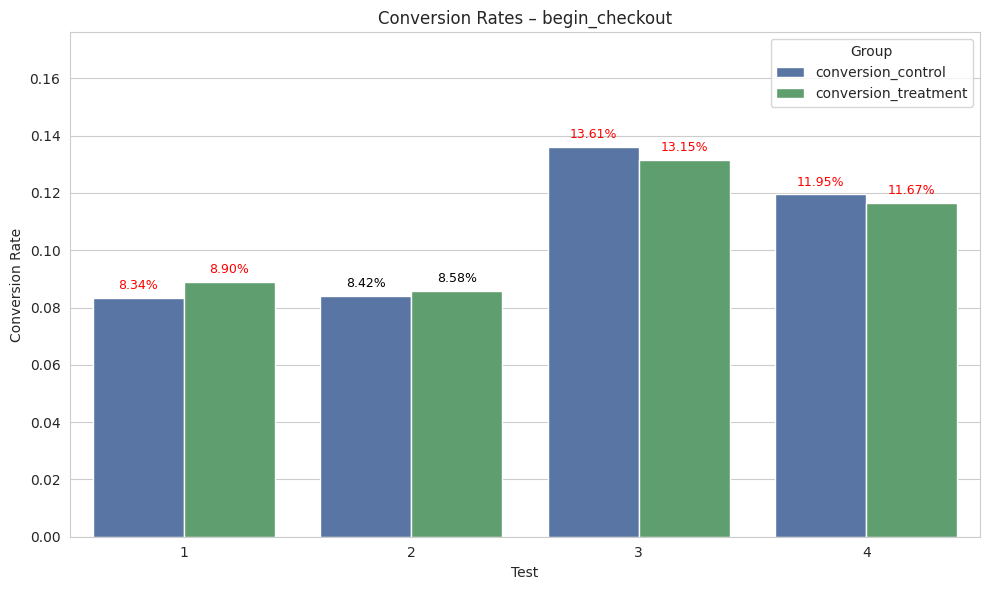

In [ ]:
event_name = 'begin_checkout'
plot_tests(df_ztest, event_name)

Отже, вказана функція показує результати для певної події у розрізі тестів, а також відмічає червоним статистично значущі результати. На прикладі begin_checkout, відмічається статистично значущий приріст у 1-му тесті та статистично значущі падіння показника у 3-му та 4-му.

Іноді, окрім зображення одиничної події, може знадобитися графік декількох подій для їх порівняння, отримання інсайтів, презентації, тощо. З цієї причини оптимізуємо функцію зображення одиничного графіка, щоб вона приймала вісь, на якій буде цей графік у складі множинної візуалізації.

In [ ]:
def plot_test_single_event(df, event_name, ax):
    df_plot = df[df['event_name'] == event_name].copy()

    if df_plot.empty:
        print(f"No data found for event: {event_name}")
        return

    df_melted = df_plot.melt(
        id_vars=['test', 'significance'],
        value_vars=['conversion_control', 'conversion_treatment'],
        var_name='group',
        value_name='conversion'
    )

    sns.set_style("whitegrid")

    sns.barplot(
        x='test',
        y='conversion',
        hue='group',
        data=df_melted,
        palette=['#4C72B0', '#55A868'],
        dodge=True,
        ax=ax
    )

    max_text_y = 0

    for bar, (_, row) in zip(ax.patches, df_melted.iterrows()):
        height = bar.get_height()
        if height < 1e-6:
            continue
        x_center = bar.get_x() + bar.get_width() / 2
        color = 'red' if row['significance'] else 'black'
        ax.text(
            x_center,
            height + 0.002,
            f"{height:.2%}",
            ha='center',
            va='bottom',
            fontsize=9,
            color=color
        )
        max_text_y = max(max_text_y, height + 0.02)

    ax.set_ylim(0, max_text_y + 0.02)
    ax.set_title(f"Conversion Rates – {event_name}")
    ax.set_xlabel("Test")
    ax.set_ylabel("Conversion Rate")
    ax.legend(title="Group")

Після цього зробимо функцію множинної візуалізації, яка прийматиме список з багатьох подій, що у подальшому будуть зображені.

In [ ]:
def plot_multiple_events(df, event_names, cols=2, figsize=(14, 5)):

    n = len(event_names)
    rows = math.ceil(n / cols)
    fig, axes = plt.subplots(rows, cols, figsize=figsize, squeeze=False)

    for i, event_name in enumerate(event_names):
        row, col = divmod(i, cols)
        ax = axes[row][col]
        plot_test_single_event(df, event_name, ax)

    for j in range(n, rows * cols):
        row, col = divmod(j, cols)
        fig.delaxes(axes[row][col])

    plt.tight_layout()
    plt.show()

Перевіримо функцію, зобразивши цікаві нам дії користувача.

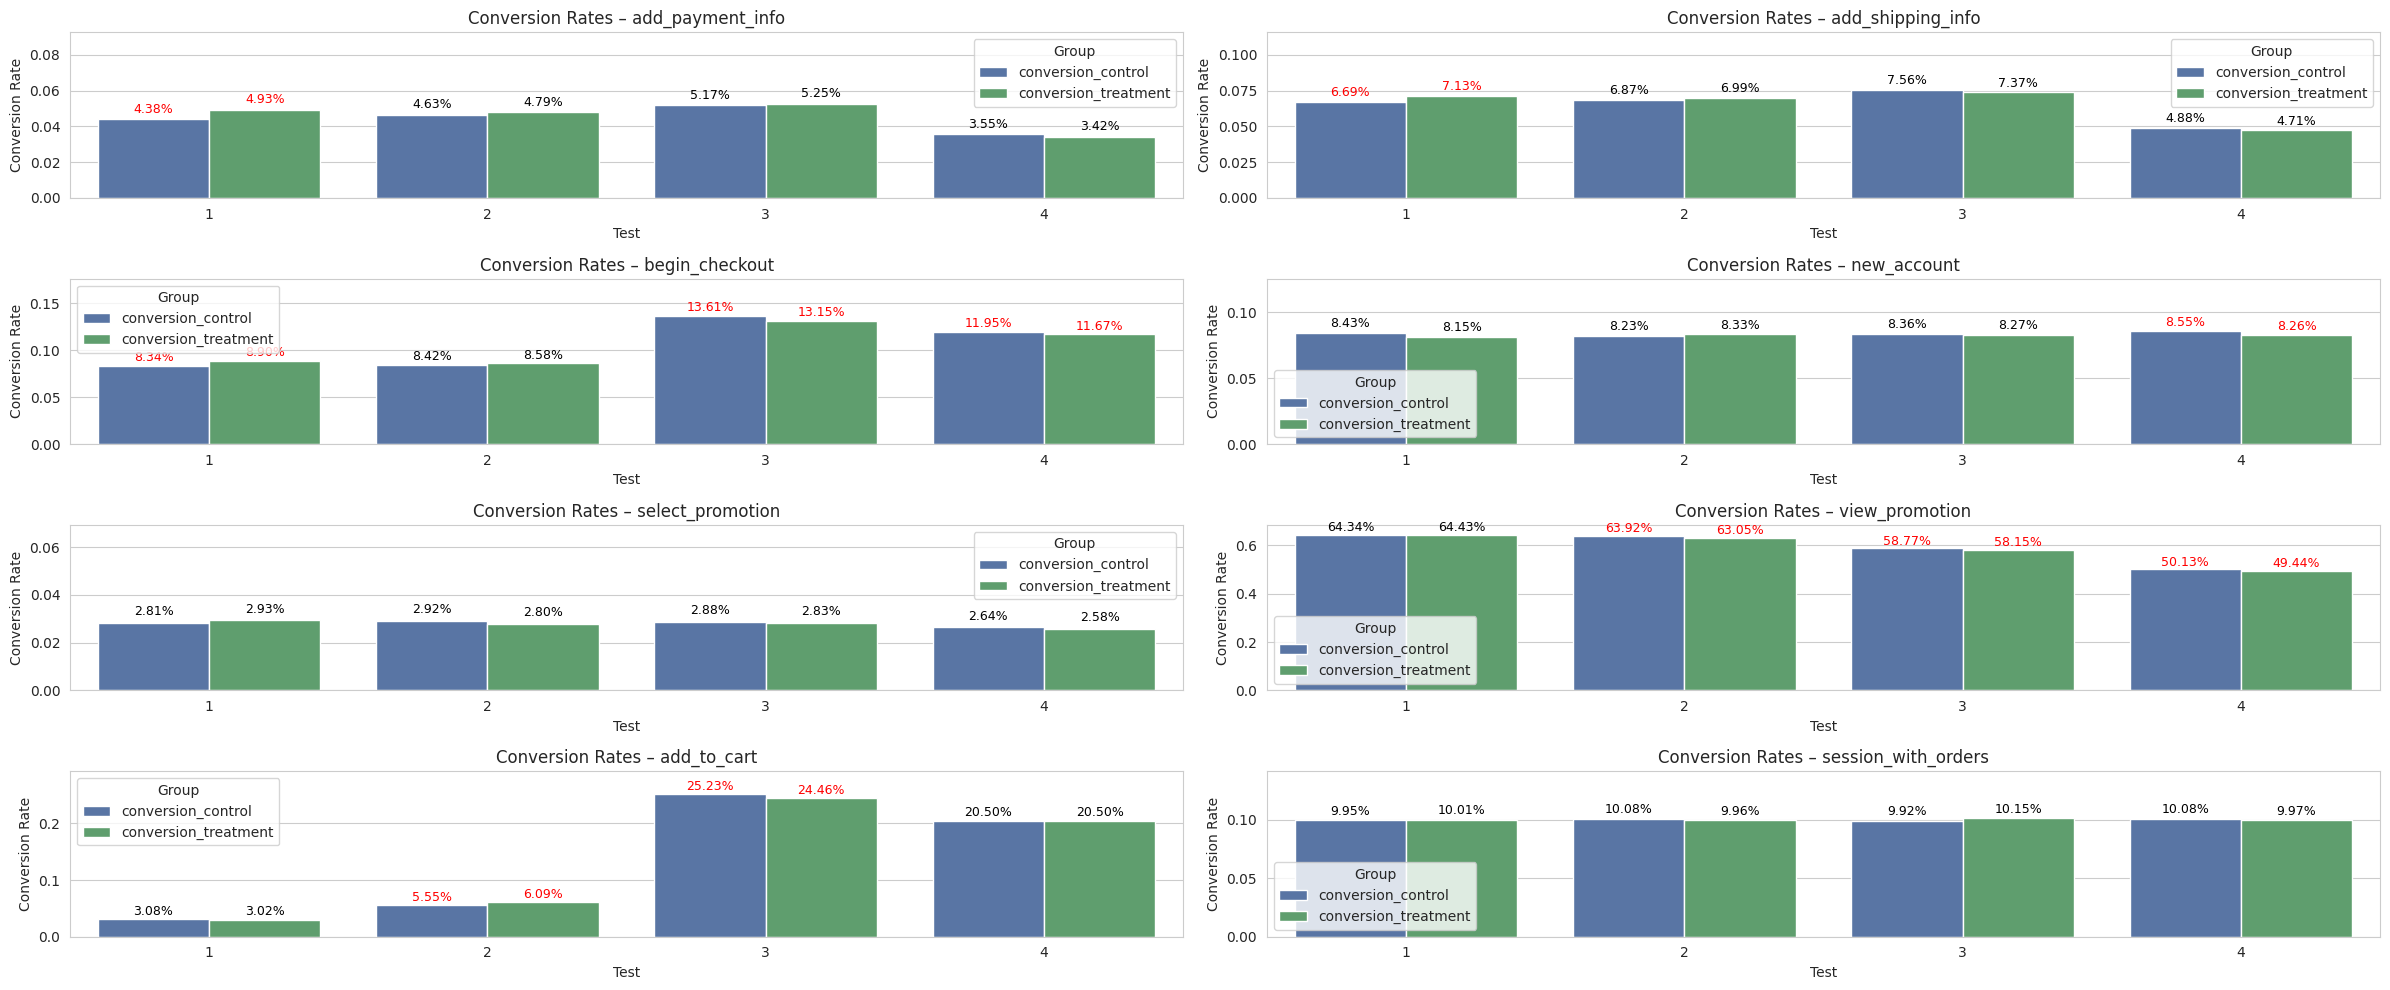

In [ ]:
event_names_plotting = ['add_payment_info', 'add_shipping_info', 'begin_checkout', 'new_account', 'select_promotion', 'view_promotion', 'add_to_cart', 'session_with_orders']

plot_multiple_events(df_ztest, event_names_plotting, figsize=(24, 10))

Маючи перед собою результати всіх тестів, можемо зробити наступні висновки:
- найбільш вдалим можна вважати тест 1, оскільки по ньому спостерігаються статистично значущі зростання декількох метрик, таких як add_payment_info, add_shipping_info, begin_checkout;
- водночас, ми не можемо сформувати повноцінний висновок, оскільки не знаємо суті протестованих змін. Незважаючи на те, що ряд метрик у ході першого тесту зріс, найважливіша з них - session_with_orders, не зазнала суттєвих змін. Оскільки зростаючі події більше відносяться до дій нових користувачів (як правило, при повторному замовленні платіжна інформація та інформація по доставці зберігається із попереднього), слід проаналізувати, чи не можуть впроваджені зміни негативно впливати на вже існуючих користувачів;
- результати другого тесту містять лише один статистично значущий результат, а третього і четвертого - негативні статистично значущі результати, що ставить під сумнів ефективність протестованих змін;
- слід також відмітити, що показник session_with_orders не міняється у жодному тесті. Можливо, це привід переглянути гіпотези щодо впливу протестованих змін на кінцевий бажаний результат, а саме - збільшення обсягу покупок;
- можна звернути увагу на різке зростання показника add_to_cart у третьому та четвертому тесті. За необхідності, можна далі досліджувати причини таких змін.

Окрім загальної картини, може бути цікавою інформація і у розрізі різних характеристик. Для цього, оптимізуємо одну з минулих функцій для групування та отримання даних тепер вже у розрізі заданих характеристик-сегментів.

In [ ]:
def prepare_grouped_df_segmented(df, event_names, segment_cols=None):
    if segment_cols is None:
        segment_cols = []

    res = pd.DataFrame()

    for event_name in event_names:
        filtered = df[df['event_name'] == event_name]
        group_keys = ['test', 'test_group'] + segment_cols
        grouped = (
            filtered
            .groupby(group_keys, observed=True)['value']
            .sum()
            .unstack(level=1)
            .fillna(0)
            .sort_index()
        )
        grouped['event_name'] = event_name
        res = pd.concat([res, grouped], axis=0)

    res.rename(columns={1: 'control', 2: 'treatment'}, inplace=True)
    res.columns.name = None
    res = res.reset_index()
    return res

Перевіримо функцію на сегментах channel, device та continent. Країни поки не будемо додавати, оскільки це означатиме значне збільшення комбінацій даних.

In [ ]:
event_names = ['session', 'add_payment_info', 'add_shipping_info', 'begin_checkout', 'new_account', 'select_promotion', 'view_promotion', 'add_to_cart', 'session_with_orders']
segment_cols = ['channel', 'device', 'continent']

grouped_df_segmented = prepare_grouped_df_segmented(df, event_names, segment_cols)
grouped_df_segmented

,test,channel,device,continent,control,treatment,event_name
0,1,Direct,desktop,(not set),15,14,session
1,1,Direct,desktop,Africa,75,45,session
2,1,Direct,desktop,Americas,3434,3348,session
3,1,Direct,desktop,Asia,1520,1428,session
4,1,Direct,desktop,Europe,1151,1149,session
...,...,...,...,...,...,...,...
2683,4,Undefined,mobile,Oceania,2,1,session_with_orders
2684,4,Undefined,tablet,Americas,13,6,session_with_orders
2685,4,Undefined,tablet,Asia,1,1,session_with_orders
2686,4,Undefined,tablet,Europe,1,1,session_with_orders


In [ ]:
grouped_df_segmented.duplicated(subset=['test', 'channel', 'device', 'continent', 'event_name']).any()

np.False_

Також оптимізуємо функцію розрахунку ztest. Оскільки у розрізі певних характеристик може бути занадто мало подій, щоб тест давав об'єктивні результати, до функції доданий відповідний фільтр.

In [ ]:
def conduct_ztest_segmented(df, segment_cols=None, significance_criteria=0.05):
    if segment_cols is None:
        segment_cols = []

    key_cols = ['test'] + segment_cols

    session_df = df[df['event_name'] == 'session'].copy()
    events_df = df[df['event_name'] != 'session'].copy()

    session_counts = session_df.set_index(key_cols)[['control', 'treatment']]
    events_df = events_df.set_index(key_cols)

    events_df = events_df.join(session_counts.rename(
        columns={'control': 'session_control', 'treatment': 'session_treatment'}
    ))

    events_df['conversion_control'] = events_df['control'] / events_df['session_control']
    events_df['conversion_treatment'] = events_df['treatment'] / events_df['session_treatment']

    events_df['metric_change'] = events_df['conversion_treatment'] / events_df['conversion_control'] - 1

    events_df = events_df[
    (events_df['control'] > 5) &
    (events_df['treatment'] > 5) &
    (events_df['control'] <= events_df['session_control']) &
    (events_df['treatment'] <= events_df['session_treatment'])
    ]

    counts = events_df[['control', 'treatment']].values
    n_obs = events_df[['session_control', 'session_treatment']].values
    ztest_results = [proportions_ztest(count, nobs_) for count, nobs_ in zip(counts, n_obs)]

    events_df['z_stat'] = [z for z, _ in ztest_results]
    events_df['p_value'] = [p for _, p in ztest_results]
    events_df['significance'] = events_df['p_value'] < significance_criteria

    return events_df.reset_index()

Перевіримо роботу функції та наявність пропущених значень.

In [ ]:
df_ztest_segmented = conduct_ztest_segmented(grouped_df_segmented, segment_cols)
df_ztest_segmented

,test,channel,device,continent,control,treatment,event_name,session_control,session_treatment,conversion_control,conversion_treatment,metric_change,z_stat,p_value,significance
0,1,Direct,desktop,Americas,129,152,add_payment_info,3434,3348,0.037566,0.0454,0.208561,-1.618646,0.105523,False
1,1,Direct,desktop,Asia,41,61,add_payment_info,1520,1428,0.026974,0.042717,0.583658,-2.337387,0.019419,True
2,1,Direct,desktop,Europe,48,56,add_payment_info,1151,1149,0.041703,0.048738,0.168697,-0.811901,0.416848,False
3,1,Direct,mobile,Americas,101,100,add_payment_info,2297,2209,0.04397,0.045269,0.029542,-0.211147,0.832773,False
4,1,Direct,mobile,Asia,30,69,add_payment_info,995,1029,0.030151,0.067055,1.224004,-3.848332,0.000119,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1315,4,Undefined,desktop,Europe,50,45,session_with_orders,609,643,0.082102,0.069984,-0.147589,0.809274,0.418357,False
1316,4,Undefined,mobile,Americas,148,132,session_with_orders,1264,1299,0.117089,0.101617,-0.132139,1.255354,0.209350,False
1317,4,Undefined,mobile,Asia,41,47,session_with_orders,487,546,0.084189,0.086081,0.022469,-0.108718,0.913426,False
1318,4,Undefined,mobile,Europe,40,40,session_with_orders,425,421,0.094118,0.095012,0.009501,-0.044444,0.964551,False


In [ ]:
df_ztest_segmented[df_ztest_segmented.isna().any(axis=1)]


,test,channel,device,continent,control,treatment,event_name,session_control,session_treatment,conversion_control,conversion_treatment,metric_change,z_stat,p_value,significance


Отже, ми отримали 1320 різних результатів у розрізі характеристик. Надалі, спробуємо спростити деякі з них, а також додати країни.

In [ ]:
grouped_continents = df.groupby('continent')['value'].sum().sort_values(ascending=False)
grouped_continents

,value
continent,
Americas,4233100
Asia,1777551
Europe,1406809
Oceania,80434
Africa,72828
(not set),19406


In [ ]:
grouped_devices = df.groupby('device')['value'].sum().sort_values(ascending=False)
grouped_devices

,value
device,
desktop,4472725
mobile,2948851
tablet,168552


In [ ]:
grouped_channels = df.groupby('channel')['value'].sum().sort_values(ascending=False)
grouped_channels

,value
channel,
Organic Search,2655946
Paid Search,1982478
Direct,1770074
Social Search,640235
Undefined,541395


In [ ]:
grouped_countries = df.groupby('country')['value'].sum().sort_values(ascending=False)
grouped_countries

,value
country,
United States,3369132
India,703131
Canada,565729
United Kingdom,238152
France,147278
...,...
Paraguay,1226
Ghana,1200
Trinidad & Tobago,1166


У всіх характеристиках, окрім device, спробуємо залишити по 3-5 найбільших значень, а всі інші згрупувати у категорію Other.

In [ ]:
df['continent_agg'] = np.where(~df['continent'].isin(grouped_continents.nlargest(3).index.to_list()), 'Other', df['continent'])
df['channel_agg'] = np.where(~df['channel'].isin(grouped_channels.nlargest(3).index.to_list()), 'Other', df['channel'])
df['country_agg'] = np.where(~df['country'].isin(grouped_countries.nlargest(5).index.to_list()), 'Other', df['country'])

print(df['continent_agg'].unique(), df['channel_agg'].unique(), df['country_agg'].unique())

['Asia' 'Americas' 'Other' 'Europe'] ['Organic Search' 'Direct' 'Other' 'Paid Search'] ['Other' 'Canada' 'France' 'India' 'United Kingdom' 'United States']


Після цього, знову проведемо групування даних та розрахунок результатів ztest.

In [ ]:
new_segment_cols = ['channel_agg', 'device', 'continent_agg', 'country_agg']
event_names = ['session', 'add_payment_info', 'add_shipping_info', 'begin_checkout', 'new_account', 'select_promotion', 'view_promotion', 'add_to_cart', 'session_with_orders']
new_segmented_df = prepare_grouped_df_segmented(df, event_names, new_segment_cols)
new_segmented_df

,test,channel_agg,device,continent_agg,country_agg,control,treatment,event_name
0,1,Direct,desktop,Americas,Canada,488,425,session
1,1,Direct,desktop,Americas,Other,214,214,session
2,1,Direct,desktop,Americas,United States,2732,2709,session
3,1,Direct,desktop,Asia,India,632,558,session
4,1,Direct,desktop,Asia,Other,888,870,session
...,...,...,...,...,...,...,...,...
3639,4,Paid Search,tablet,Asia,Other,13,12,session_with_orders
3640,4,Paid Search,tablet,Europe,France,1,1,session_with_orders
3641,4,Paid Search,tablet,Europe,Other,10,7,session_with_orders
3642,4,Paid Search,tablet,Europe,United Kingdom,2,2,session_with_orders


In [ ]:
new_df_ztest_segmented = conduct_ztest_segmented(new_segmented_df, new_segment_cols)
new_df_ztest_segmented

,test,channel_agg,device,continent_agg,country_agg,control,treatment,event_name,session_control,session_treatment,conversion_control,conversion_treatment,metric_change,z_stat,p_value,significance
0,1,Direct,desktop,Americas,Canada,7,25,add_payment_info,488,425,0.014344,0.058824,3.10084,-3.645310,0.000267,True
1,1,Direct,desktop,Americas,Other,10,10,add_payment_info,214,214,0.046729,0.046729,0.0,0.000000,1.000000,False
2,1,Direct,desktop,Americas,United States,112,117,add_payment_info,2732,2709,0.040996,0.043189,0.053512,-0.402952,0.686983,False
3,1,Direct,desktop,Asia,India,21,30,add_payment_info,632,558,0.033228,0.053763,0.618024,-1.745458,0.080905,False
4,1,Direct,desktop,Asia,Other,20,31,add_payment_info,888,870,0.022523,0.035632,0.582069,-1.637439,0.101539,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2207,4,Paid Search,mobile,Europe,United Kingdom,41,32,session_with_orders,348,364,0.117816,0.087912,-0.253819,1.314915,0.188538,False
2208,4,Paid Search,mobile,Other,Other,18,28,session_with_orders,249,277,0.072289,0.101083,0.398315,-1.167167,0.243143,False
2209,4,Paid Search,tablet,Americas,United States,41,30,session_with_orders,313,298,0.13099,0.100671,-0.231462,1.168944,0.242426,False
2210,4,Paid Search,tablet,Asia,Other,13,12,session_with_orders,92,86,0.141304,0.139535,-0.012522,0.033953,0.972915,False


Бачимо, що в результаті спрощення категорій та додавання країн ми отримали 2212 результатів тестів.

Звичайно, подібні дані всі зразу не знадобляться, тому напишемо функцію для виведення результатів по заданим характеристикам.

In [ ]:
def print_tests(
    df,
    test=None,
    channel=None,
    device=None,
    continent=None,
    country=None,
    event_name=None
):

    conditions = []

    if test is not None:
        conditions.append(df['test'].isin(test))
    if channel is not None:
        conditions.append(df['channel_agg'].isin(channel))
    if device is not None:
        conditions.append(df['device'].isin(device))
    if continent is not None:
        conditions.append(df['continent_agg'].isin(continent))
    if country is not None:
        conditions.append(df['country_agg'].isin(country))
    if event_name is not None:
        conditions.append(df['event_name'].isin(event_name))

    if conditions:
        combined_condition = conditions[0]
        for cond in conditions[1:]:
            combined_condition &= cond
        filtered_df = df[combined_condition]
    else:
        filtered_df = df

    if filtered_df.empty:
        return "No matching tests found."
    else:
        return filtered_df

Приклад роботи функції виведення результатів по заданим характеристикам.

In [ ]:
test_select = [2]
channel_select = ['Direct']
device_select = ['desktop']
country_select = ['United States']
continent_select = ['Americas', 'Europe']
event_select = ['add_payment_info']

print_tests(new_df_ztest_segmented, test=test_select, channel=channel_select, device=device_select, continent=continent_select, event_name=event_select)

,test,channel_agg,device,continent_agg,country_agg,control,treatment,event_name,session_control,session_treatment,conversion_control,conversion_treatment,metric_change,z_stat,p_value,significance
51,2,Direct,desktop,Americas,Canada,17,21,add_payment_info,495,521,0.034343,0.040307,0.173648,-0.500749,0.616547,False
52,2,Direct,desktop,Americas,Other,12,8,add_payment_info,245,239,0.04898,0.033473,-0.316597,0.856944,0.391476,False
53,2,Direct,desktop,Americas,United States,106,142,add_payment_info,2982,3054,0.035547,0.046496,0.30804,-2.142784,0.032130,True
56,2,Direct,desktop,Europe,France,15,14,add_payment_info,155,130,0.096774,0.107692,0.112821,-0.303661,0.761386,False
57,2,Direct,desktop,Europe,Other,36,51,add_payment_info,955,938,0.037696,0.054371,0.442342,-1.732276,0.083224,False


Також напишемо і протестуємо функцію зображення результатів тесту по заданим характеристикам.

In [ ]:
def plot_test_single_event(
    df,
    ax,
    event_name,
    test,
    country,
    continent,
    channel,
    device
):

    df_filtered = df[
        (df['event_name'] == event_name) &
        (df['test'] == test) &
        (df['country_agg'] == country) &
        (df['continent_agg'] == continent) &
        (df['channel_agg'] == channel) &
        (df['device'] == device)
    ]

    if df_filtered.empty:
        print("No data found for the specified filters.")
        return

    df_melted = df_filtered.melt(
        id_vars=['test', 'significance'],
        value_vars=['conversion_control', 'conversion_treatment'],
        var_name='group',
        value_name='conversion'
    )

    sns.set_style("whitegrid")
    sns.barplot(
        x='test',
        y='conversion',
        hue='group',
        data=df_melted,
        palette=['#4C72B0', '#55A868'],
        dodge=True,
        ax=ax,
        errorbar=None
    )

    max_text_y = 0
    for bar, (_, row) in zip(ax.patches, df_melted.iterrows()):
        height = bar.get_height()
        if height < 1e-6:
            continue
        x_center = bar.get_x() + bar.get_width() / 2
        color = 'red' if row['significance'] else 'black'
        ax.text(
            x_center,
            height + 0.002,
            f"{height:.2%}",
            ha='center',
            va='bottom',
            fontsize=9,
            color=color
        )
        max_text_y = max(max_text_y, height + 0.02)

    ax.set_ylim(0, max_text_y + 0.02)
    ax.set_title(f"Conversion Rates – {event_name} for {country},\n{device}, {channel} (Test {test})")
    ax.set_xlabel("Test")
    ax.set_ylabel("Conversion Rate")
    ax.legend(title="Group")


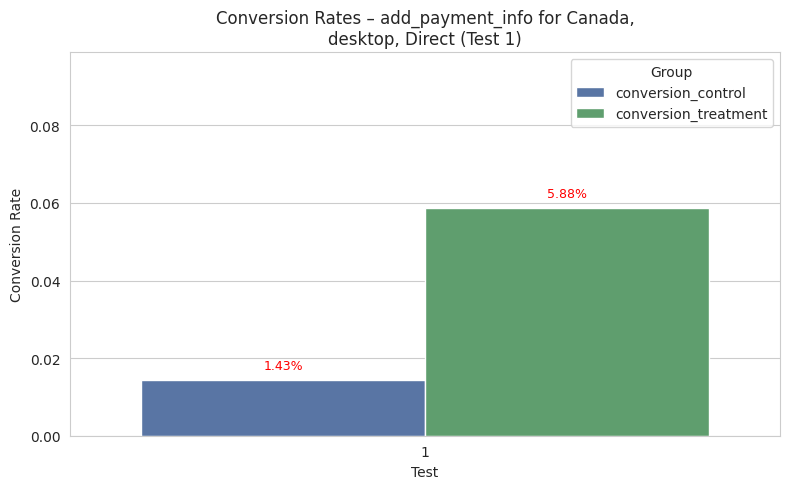

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))
plot_test_single_event(
    new_df_ztest_segmented,
    ax=ax,
    event_name='add_payment_info',
    test=1,
    continent='Americas',
    country='Canada',
    channel='Direct',
    device='desktop'
)
plt.tight_layout()
plt.show()

За бажанням, можна будувати графіки з декількома результатами, передаваючи відповідні осі у функцію.

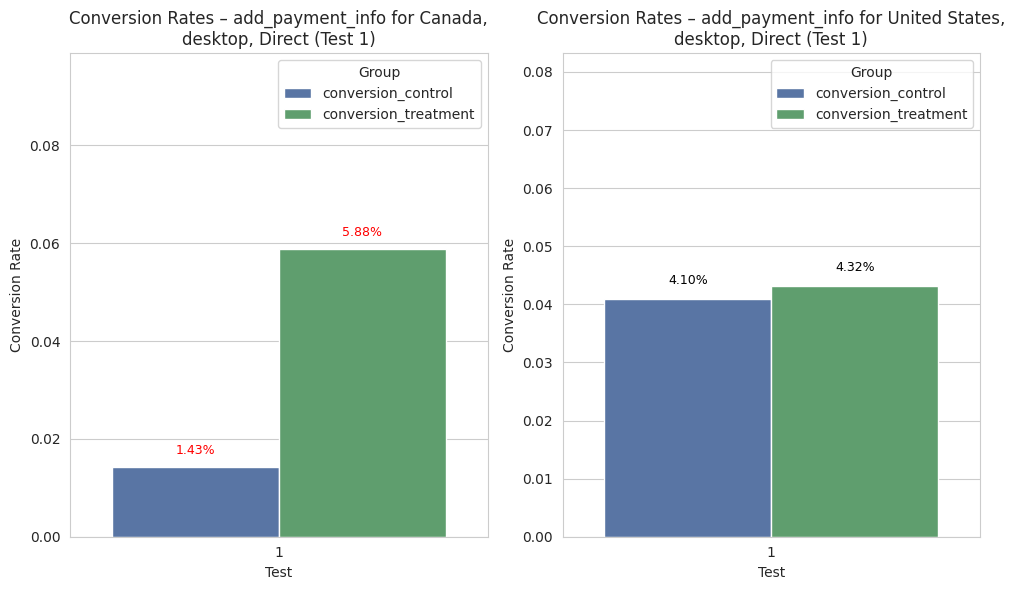

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

plot_test_single_event(
    new_df_ztest_segmented,
    ax=axes[0],
    event_name='add_payment_info',
    test=1,
    continent='Americas',
    country='Canada',
    channel='Direct',
    device='desktop'
)

plot_test_single_event(
    new_df_ztest_segmented,
    ax=axes[1],
    event_name='add_payment_info',
    test=1,
    continent='Americas',
    country='United States',
    channel='Direct',
    device='desktop'
)

plt.tight_layout()
plt.show()

Також підготуємо дані для їх подальшого використання у візуалізації в Tableau. Для цього об'єднаємо датасети із загальною інформацією та інформацією у розрізі різних характеристик. Для їх успішного об'єднання потрібно привести їх до однакової структури.

In [ ]:
print([x for x in new_df_ztest_segmented.columns if x not in df_ztest.columns])

['channel_agg', 'device', 'continent_agg', 'country_agg']


In [ ]:
df_ztest['channel_agg'] = 'All channels'
df_ztest['country_agg'] = 'All countries'
df_ztest['device'] = 'All devices'
df_ztest['continent_agg'] = 'All continents'
print([x for x in new_df_ztest_segmented.columns if x not in df_ztest.columns])

[]


In [ ]:
df_ztest = df_ztest[new_df_ztest_segmented.columns]
total_df = pd.concat([df_ztest, new_df_ztest_segmented], ignore_index=True)
total_df.head()

,test,channel_agg,device,continent_agg,country_agg,control,treatment,event_name,session_control,session_treatment,conversion_control,conversion_treatment,metric_change,z_stat,p_value,significance
0,1,All channels,All devices,All continents,All countries,1988,2229,add_payment_info,45362,45193,0.043825,0.049322,0.12542,-3.924884,0.000087,True
1,2,All channels,All devices,All continents,All countries,2344,2409,add_payment_info,50637,50244,0.04629,0.047946,0.035769,-1.240994,0.214608,False
2,3,All channels,All devices,All continents,All countries,3623,3697,add_payment_info,70047,70439,0.051722,0.052485,0.014746,-0.643172,0.520112,False
3,4,All channels,All devices,All continents,All countries,3731,3601,add_payment_info,105079,105141,0.035507,0.034249,-0.035412,1.571106,0.116158,False
4,1,All channels,All devices,All continents,All countries,3034,3221,add_shipping_info,45362,45193,0.066884,0.071272,0.065605,-2.603571,0.009226,True


Також перевіримо відсутні значення.

In [ ]:
total_df.isna().sum().sum()

np.int64(0)

In [ ]:
total_df['channel_agg'].value_counts()

,count
channel_agg,
Organic Search,601
Paid Search,563
Direct,545
Other,503
All channels,32


In [ ]:
total_df = total_df.rename(columns={'channel_agg': 'channel', 'continent_agg': 'continent', 'country_agg': 'country'})
total_df.head()

,test,channel,device,continent,country,control,treatment,event_name,session_control,session_treatment,conversion_control,conversion_treatment,metric_change,z_stat,p_value,significance
0,1,All channels,All devices,All continents,All countries,1988,2229,add_payment_info,45362,45193,0.043825,0.049322,0.12542,-3.924884,0.000087,True
1,2,All channels,All devices,All continents,All countries,2344,2409,add_payment_info,50637,50244,0.04629,0.047946,0.035769,-1.240994,0.214608,False
2,3,All channels,All devices,All continents,All countries,3623,3697,add_payment_info,70047,70439,0.051722,0.052485,0.014746,-0.643172,0.520112,False
3,4,All channels,All devices,All continents,All countries,3731,3601,add_payment_info,105079,105141,0.035507,0.034249,-0.035412,1.571106,0.116158,False
4,1,All channels,All devices,All continents,All countries,3034,3221,add_shipping_info,45362,45193,0.066884,0.071272,0.065605,-2.603571,0.009226,True


На завершення, експортуємо датафрейм у Excel файл для подальшого використання.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/My Drive/mate_academy_da/projects/project_2'

/content/drive/My Drive/mate_academy_da/projects/project_2


In [ ]:
total_df.to_excel('ztest_results.xlsx', index=False)

In [ ]:
ls

ab_testing.ipynb  ztest_results.xlsx


Посилання на візуалізацію у Tableau Public: [Візуалізація](https://public.tableau.com/views/ABtesting_new_proj/ABtest?:language=en-US&publish=yes&:sid=&:redirect=auth&:display_count=n&:origin=viz_share_link)


Посилання на файл з результатами z-тесту: [Дані](https://docs.google.com/spreadsheets/d/1n1zqzdi8ZskFxyX-Kifz_5UYIzeQ2gJ7/edit?usp=sharing&ouid=110110082425674159257&rtpof=true&sd=true)

Отже, за результатами короткого мініпроекту:
- Був проведений огляд даних;
- Дані були згруповані у необхідний формат для проведення z-тесту;
- Проведення z-тестів було спрощене та автоматизоване за допомогою функцій;
- Окрім цього, за допомогою функцій оптимізоване виведення та візуалізація результатів z-тесту у розрізі різних параметрів;
- В процесі, були здійснені висновки щодо самих проведених тестів, основний з яких - перший тест виявився успішнішим відносно всіх інших, однак жоден з них не мав значущого впливу на обсяг замовлень. Щоправда, не знаючи суті тестів та гіпотез перед їх проведенням, неможливо повністю зробити висновки щодо їх проведення. Можливо, протестовані зміни мають більш довгостроковий вплив на продажі і направлені в першу чергу на збільшення клієнтської бази, наприклад. В такому випадку протестовані зміни виправдали себе там, де спостерігалося зростання рівня конверсії із статистично значущими результатами.